In [ ]:
!pip install torch

In [ ]:
!pip install scikit-learn

In [ ]:
!pip install soundfile pandas

In [ ]:
!pip install pip==24.00

In [ ]:
!pip install pyyaml fairseq

In [6]:
import os
import torch
import fairseq
import soundfile as sf
import pandas as pd

model_path = './Downloads/wav2vec_small.pt' 
model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([model_path])
model = model[0]
model.eval()

# Function to split audio into 2-second chunks
def split_audio_into_chunks(audio, sr, chunk_duration=2):
    chunk_length = chunk_duration * sr
    chunks = []
    for i in range(0, len(audio), chunk_length):
        chunk = audio[i:i + chunk_length]
        if len(chunk) == chunk_length:
            chunks.append(chunk)
    return chunks

# Mean-pool the features over the sequence dimension
def extract_features_from_chunk(chunk, sr):
    audio_tensor = torch.from_numpy(chunk).float().unsqueeze(0)
    with torch.no_grad():
        features = model.feature_extractor(audio_tensor)
    return features.mean(dim=2).squeeze().numpy()  # Mean-pool to reduce to 512-dim

base_path = './Downloads/LibriSpeech/dev-clean/'

features_wav2vec = []
labels = []

# Loop over each speaker directory
for speaker_id in os.listdir(base_path):
    speaker_path = os.path.join(base_path, speaker_id)

    if not os.path.isdir(speaker_path):
        continue

    # Loop over each chapter directory within the speaker directory
    for chapter_id in os.listdir(speaker_path):
        chapter_path = os.path.join(speaker_path, chapter_id)

        if not os.path.isdir(chapter_path):
            continue

        # Loop over each .flac file in the chapter directory
        for audio_file in os.listdir(chapter_path):
            if audio_file.endswith('.flac'):
                file_path = os.path.join(chapter_path, audio_file)

                # Load the audio file using soundfile
                audio, sr = sf.read(file_path)

                if sr != 16000:
                    raise ValueError(f"Expected 16 kHz audio, but got {sr} Hz")

                # Split the audio into 2-second chunks
                chunks = split_audio_into_chunks(audio, sr, chunk_duration=2)

                # Extract features for each chunk
                for chunk in chunks:
                    wav2vec_features = extract_features_from_chunk(chunk, sr)
                    features_wav2vec.append(wav2vec_features)

                    # Store the speaker ID as the label for each chunk
                    labels.append(speaker_id)

df_wav2vec = pd.DataFrame(features_wav2vec)
df_wav2vec['speaker_id'] = labels

print(df_wav2vec.head())


/opt/anaconda3/envs/py-38/lib/python3.8/site-packages/fairseq/checkpoint_utils.py:315: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(f, map_location=torch

          0         1         2         3         4         5         6  \
0 -0.001404 -0.001754 -0.002755 -0.003818  0.004183 -0.000176 -0.005204   
1 -0.000503 -0.003341 -0.006087 -0.006688  0.000049  0.002898 -0.005107   
2  0.003947 -0.004229 -0.006419 -0.001311 -0.001191  0.000322 -0.012550   
3  0.000200 -0.004892 -0.005308 -0.001899  0.000366 -0.000804 -0.007192   
4  0.004775 -0.000642 -0.002916 -0.002573 -0.002124  0.001038 -0.006375   

          7         8         9  ...       503       504       505       506  \
0 -0.000542 -0.002809 -0.002789  ... -0.010994 -0.003477 -0.001138 -0.001333   
1  0.001287 -0.000595 -0.006859  ... -0.009991 -0.005543 -0.003827 -0.004267   
2  0.002113  0.005127  0.001201  ... -0.007397 -0.009213 -0.002939 -0.005889   
3  0.001754 -0.000788 -0.000937  ... -0.008129 -0.004575 -0.005986 -0.002422   
4  0.004824 -0.003284 -0.002922  ... -0.012955 -0.002423 -0.004841  0.001983   

        507       508       509       510       511  speaker_id  
0 

In [7]:
df_wav2vec.info()
print(df_wav2vec['speaker_id'].unique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8392 entries, 0 to 8391
Columns: 513 entries, 0 to speaker_id
dtypes: float32(512), object(1)
memory usage: 16.5+ MB
['2412' '2078' '3752' '1988' '1919' '422' '3000' '1993' '6313' '251'
 '8842' '5536' '7850' '174' '6295' '7976' '2803' '777' '5694' '1462'
 '5895' '2086' '6241' '2277' '2428' '3536' '2902' '8297' '3081' '6345'
 '652' '3853' '5338' '6319' '3170' '1272' '84' '3576' '1673' '2035']


In [28]:
speaker_distribution = df_wav2vec['speaker_id'].value_counts()
print(speaker_distribution)
len(df_wav2vec['speaker_id'])

speaker_id
422     234
2902    225
1673    221
3576    221
3000    220
2803    219
174     218
5536    217
2078    217
3170    216
8842    215
6319    215
3536    213
1993    213
2086    213
3853    212
1919    212
2412    212
84      211
5338    211
652     210
7850    210
1988    209
7976    208
6345    208
6295    207
6241    206
8297    205
1272    204
2035    204
1462    203
777     203
5895    203
251     201
5694    199
2428    198
6313    198
3752    197
2277    193
3081    191
Name: count, dtype: int64


8392

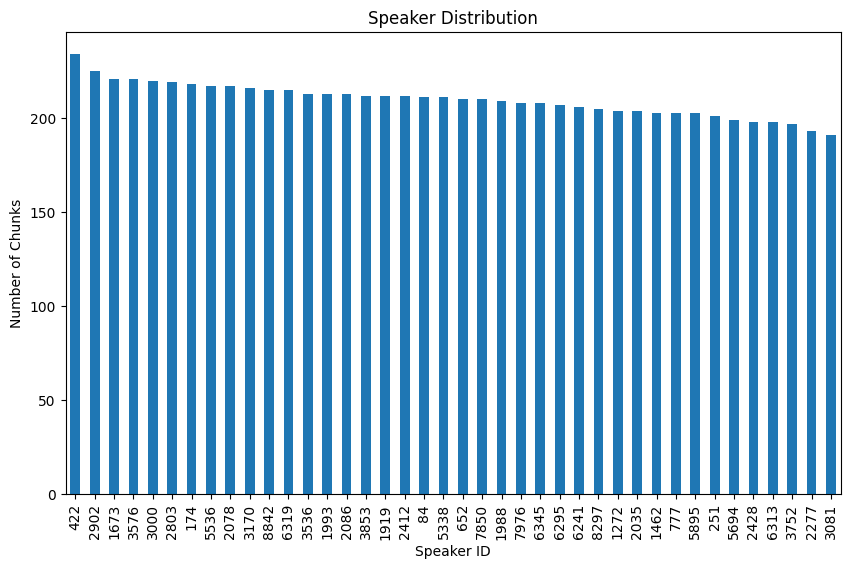

In [21]:
plt.figure(figsize=(10, 6))
speaker_distribution.plot(kind='bar')
plt.title('Speaker Distribution')
plt.xlabel('Speaker ID')
plt.ylabel('Number of Chunks')
plt.show()

The bar plot visualizes the number of data for each speaker in the dataset. This distribution is important for understanding the representation of different speakers in the dataset and identifying potential imbalances.

The plot reveals that some speakers have less data than others. Although the variation isn't extreme, the difference could impact model performance, especially if the model is trained on this data for tasks such as speaker identification.

It’s important to address this potential imbalance in further analyses or model training to ensure the results are not biased toward speakers with more data. Balancing the dataset method could help mitigate this issue.

In [20]:
print(df_wav2vec.isnull().sum())


0             0
1             0
2             0
3             0
4             0
             ..
508           0
509           0
510           0
511           0
speaker_id    0
Length: 513, dtype: int64


In [77]:

min_samples = df_wav2vec_scaled['speaker_id'].value_counts().min()

balanced_df_list = []

for speaker in df_wav2vec_scaled['speaker_id'].unique():
    speaker_data = df_wav2vec_scaled[df_wav2vec_scaled['speaker_id'] == speaker]
    
    speaker_sample = speaker_data.sample(n=min_samples, random_state=42)
    
    balanced_df_list.append(speaker_sample)
# all the samples to form the balanced dataset
balanced_df = pd.concat(balanced_df_list).reset_index(drop=True)

print(balanced_df['speaker_id'].value_counts())


speaker_id
2412    191
2078    191
6241    191
2277    191
2428    191
3536    191
2902    191
8297    191
3081    191
6345    191
652     191
3853    191
5338    191
6319    191
3170    191
1272    191
84      191
3576    191
1673    191
2086    191
5895    191
1462    191
251     191
3752    191
1988    191
1919    191
422     191
3000    191
1993    191
6313    191
8842    191
5694    191
5536    191
7850    191
174     191
6295    191
7976    191
2803    191
777     191
2035    191
Name: count, dtype: int64


The dataset has been balanced, with each speaker now having exactly 191 samples. This step is critical in ensuring that subsequent analysis and modeling do not suffer from class imbalance, which can manipulate model performance and reduce its ability to generalize.


In [64]:
from sklearn.preprocessing import StandardScaler

X = balanced_df.drop(columns=['speaker_id'])
y = balanced_df['speaker_id'] 

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

balanced_df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
balanced_df_scaled['speaker_id'] = y.values

print(balanced_df_scaled.head())


          0         1         2         3         4         5         6  \
0  0.882149  0.612043  1.009491 -1.153647  0.855257  0.383136 -0.114922   
1  1.857709 -0.392767 -2.347843 -0.377997 -1.516910  0.846782 -1.574127   
2 -1.098223 -2.450008 -2.366465  0.084495 -0.935791  0.322103  0.121003   
3  0.438807 -0.733737 -0.931112 -1.586870  0.815922  0.633288 -0.825151   
4  1.392844 -0.054504 -0.827755 -1.978208  0.851917  0.425256 -2.031245   

          7         8         9  ...       503       504       505       506  \
0 -0.985691 -2.588168 -0.500510  ...  0.580222 -0.383225 -0.641424 -0.139332   
1 -0.055425 -0.373255  0.859485  ... -0.385492 -0.255492 -1.958723 -0.991441   
2  1.420143 -1.657827  1.325536  ... -1.398205  1.368885 -1.228926 -1.577487   
3  0.724387  0.402966 -0.567725  ... -0.833070 -0.035707 -0.421051  0.065944   
4 -0.359438 -1.638455 -0.967727  ... -0.620433 -1.233357 -2.914191  1.190979   

        507       508       509       510       511  speaker_id  
0 

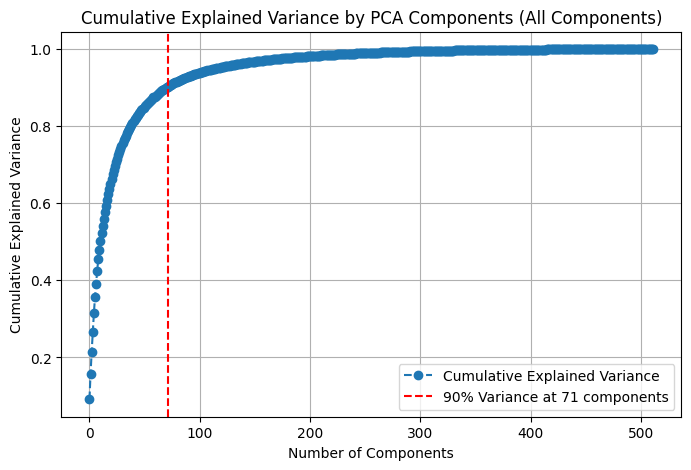

Number of components to retain 90.0% variance: 71


In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Step 2: Perform PCA on the standardized data
pca_full = PCA().fit(X_scaled)

# Step 3: Compute cumulative explained variance from the PCA fit
cumulative_explained_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Step 4: Set cumulative variance threshold (e.g., 90%)
threshold = 0.90

# Step 5: Find the number of components needed to explain 90% variance
num_components = np.argmax(cumulative_explained_variance >= threshold) + 1

# Step 6: Plot the cumulative explained variance with the elbow point
plt.figure(figsize=(8, 5))
plt.plot(cumulative_explained_variance, marker='o', linestyle='--', label='Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components (All Components)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

# Step 7: Add vertical line to show the number of components for 90% variance
plt.axvline(x=num_components, color='red', linestyle='--', label=f'90% Variance at {num_components} components')
plt.legend()
plt.grid(True)
plt.show()

# Output the number of components needed for 90% variance
print(f"Number of components to retain {threshold*100}% variance: {num_components}")


------
Principal Component Analysis (PCA) is used to reduce the dimensionality of a dataset while retaining a significant portion of the variance. The analysis specifically aims to identify how many principal components are needed to explain 90% of the variance in the dataset.
By applying PCA,The plot shows that we can reduce the dimensionality of the dataset from 512 components to  71, while still retaining 90% of the variance. This result is particularly valuable in applications where reducing the number of features can improve computational efficiency and model performance without losing critical information. The plot clearly demonstrates the diminishing returns of adding more components, helping to justify the selection of 71 components for further analysis or model development.

In [89]:
from sklearn.model_selection import train_test_split

X_t = balanced_df_scaled.drop(columns=['speaker_id'])
Y_t = balanced_df_scaled['speaker_id']

X_train, X_test, y_train, y_test = train_test_split( X_t,Y_t,test_size=0.2,random_state=42, 
    stratify=Y_t)

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of samples per speaker in the test set
speaker_test = y_test.value_counts()
speakers = y_train.value_counts()

print(speakers,speaker_test )

speaker_id
2428    153
251     153
1673    153
8842    153
5536    153
652     153
777     153
6319    153
1988    153
2902    153
2412    153
1272    153
422     153
174     153
5338    153
2078    153
7850    153
3752    153
5694    153
1919    153
7976    153
6313    153
8297    153
3081    153
3000    153
6295    153
5895    153
3536    153
1462    153
1993    153
2086    153
6345    153
3576    152
2803    152
6241    152
84      152
3170    152
3853    152
2277    152
2035    152
Name: count, dtype: int64 speaker_id
2803    39
2277    39
84      39
3576    39
6241    39
3170    39
2035    39
3853    39
251     38
6345    38
1462    38
6313    38
5694    38
422     38
2412    38
2902    38
8842    38
1919    38
2086    38
1988    38
777     38
5338    38
3081    38
5895    38
7976    38
2078    38
5536    38
8297    38
3536    38
3000    38
1993    38
7850    38
1272    38
2428    38
652     38
6295    38
6319    38
174     38
1673    38
3752    38
Name: count, dtype: int64


In [84]:
from sklearn.metrics import confusion_matrix, classification_report

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Accuracy: 0.9600785340314136
              precision    recall  f1-score   support

        1272       0.97      1.00      0.99        38
        1462       0.90      0.95      0.92        38
        1673       0.95      1.00      0.97        38
         174       0.95      1.00      0.97        38
        1919       0.93      0.97      0.95        38
        1988       1.00      0.97      0.99        38
        1993       1.00      0.95      0.97        38
        2035       0.93      0.95      0.94        39
        2078       0.97      0.97      0.97        38
        2086       0.95      1.00      0.97        38
        2277       0.95      0.90      0.92        39
        2412       0.95      0.95      0.95        38
        2428       0.95      0.97      0.96        38
         251       0.97      0.89      0.93        38
        2803       1.00      1.00      1.00        39
        2902       1.00      1.00      1.00        38
        3000       0.95      0.97      0.96        3

In [94]:
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

# Prepare data for PyTorch
X_t = balanced_df_scaled.drop(columns=['speaker_id']).values.astype(np.float32)
Y_t = balanced_df_scaled['speaker_id']

# Encode speaker IDs into numeric labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(Y_t)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_t, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # CrossEntropyLoss expects LongTensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)    # Same here for test labels

# Define the DNN model
class DNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

# Hyperparameters
input_dim = X_train.shape[1]  # 512 features
hidden_dim = 128
output_dim = len(np.unique(y_encoded))  # Number of speakers

# Initialize model, loss, and optimizer
model = DNN(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Move data to GPU if available
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Training function
def train_model(model, criterion, optimizer, X_train, y_train, num_epochs=40):
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Train the DNN model
train_model(model, criterion, optimizer, X_train_tensor, y_train_tensor)

# Evaluation function
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test).sum().item() / y_test.size(0)
        print(f'Accuracy: {accuracy * 100:.2f}%')

# Evaluate the DNN model
evaluate_model(model, X_test_tensor, y_test_tensor)


Epoch [5/40], Loss: 3.4556
Epoch [10/40], Loss: 3.0445
Epoch [15/40], Loss: 2.4541
Epoch [20/40], Loss: 1.7729
Epoch [25/40], Loss: 1.1562
Epoch [30/40], Loss: 0.7110
Epoch [35/40], Loss: 0.4258
Epoch [40/40], Loss: 0.2536
Accuracy: 93.78%


In [91]:

# Define the DNN model with batch size, hidden layer size, and learning rate as hyperparameters
class DNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

def train_model_with_batches(model, criterion, optimizer, train_loader, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Print loss for every 5th epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test).sum().item() / y_test.size(0)
        return accuracy

# Hyperparameter grid
batch_sizes = [32, 64, 128]
learning_rates = [0.001, 0.0005, 0.0001]
hidden_dims = [64, 128, 256]
num_epochs = 20

best_accuracy = 0.0
best_params = {}

for batch_size in batch_sizes:
    for lr in learning_rates:
        for hidden_dim in hidden_dims:
            print(f"\nTraining with batch_size={batch_size}, learning_rate={lr}, hidden_dim={hidden_dim}")
            
            # Create DataLoader for current batch size
            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
            train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
            
            # Initialize the model
            input_dim = X_train.shape[1]  # Number of input features (512)
            output_dim = len(np.unique(y_encoded))  # Number of speakers
            model = DNN(input_dim, hidden_dim, output_dim)
            
            # Initialize optimizer and loss function
            optimizer = optim.Adam(model.parameters(), lr=lr)
            criterion = nn.CrossEntropyLoss()

            # Train the model with the current hyperparameters
            train_model_with_batches(model, criterion, optimizer, train_loader, num_epochs)
            
            # Evaluate the model on the test set
            accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)
            print(f"Accuracy: {accuracy * 100:.2f}%")
            
            # Check if this combination gives the best accuracy
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {
                    'batch_size': batch_size,
                    'learning_rate': lr,
                    'hidden_dim': hidden_dim
                }

# Print the best hyperparameters and accuracy
print(f"\nBest Accuracy: {best_accuracy * 100:.2f}%")
print(f"Best Hyperparameters: {best_params}")



Training with batch_size=32, learning_rate=0.001, hidden_dim=64
Epoch [5/20], Loss: 0.0070
Epoch [10/20], Loss: 0.0013
Epoch [15/20], Loss: 0.0005
Epoch [20/20], Loss: 0.0002
Accuracy: 99.61%

Training with batch_size=32, learning_rate=0.001, hidden_dim=128
Epoch [5/20], Loss: 0.0024
Epoch [10/20], Loss: 0.0005
Epoch [15/20], Loss: 0.0002
Epoch [20/20], Loss: 0.0001
Accuracy: 99.61%

Training with batch_size=32, learning_rate=0.001, hidden_dim=256
Epoch [5/20], Loss: 0.0009
Epoch [10/20], Loss: 0.0002
Epoch [15/20], Loss: 0.0001
Epoch [20/20], Loss: 0.0000
Accuracy: 99.54%

Training with batch_size=32, learning_rate=0.0005, hidden_dim=64
Epoch [5/20], Loss: 0.0297
Epoch [10/20], Loss: 0.0044
Epoch [15/20], Loss: 0.0015
Epoch [20/20], Loss: 0.0007
Accuracy: 99.61%

Training with batch_size=32, learning_rate=0.0005, hidden_dim=128
Epoch [5/20], Loss: 0.0093
Epoch [10/20], Loss: 0.0017
Epoch [15/20], Loss: 0.0006
Epoch [20/20], Loss: 0.0003
Accuracy: 99.48%

Training with batch_size=32, 

In [95]:
class DNNWithDropout(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.3):
        super(DNNWithDropout, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob) 

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.dropout(out)  
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        return out

model = DNNWithDropout(input_dim=512, hidden_dim=128, output_dim=len(np.unique(y_encoded)), dropout_prob=0.5)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # weight_decay applies L2 regularization


In [96]:

from sklearn.model_selection import KFold


# Define the DNN model with batch size, hidden layer size, and learning rate as hyperparameters
class DNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

# Training function using mini-batches
def train_model_with_batches(model, criterion, optimizer, train_loader, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Print loss for every 5th epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test).sum().item() / y_test.size(0)
        return accuracy

# Hyperparameter grid
batch_sizes = [32, 64, 128]
learning_rates = [0.001, 0.005]
hidden_dims = [64, 128]
num_epochs = 30
num_folds = 5  # Number of K-Folds for cross-validation

# Perform hyperparameter tuning with cross-validation
best_accuracy = 0.0
best_params = {}

kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

for batch_size in batch_sizes:
    for lr in learning_rates:
        for hidden_dim in hidden_dims:
            fold_accuracies = []
            print(f"\nTraining with batch_size={batch_size}, learning_rate={lr}, hidden_dim={hidden_dim}")
            
            # Cross-validation loop
            for fold, (train_idx, test_idx) in enumerate(kf.split(X_tensor)):
                print(f"\nFold {fold+1}/{num_folds}")
                
                # Create train and test tensors for this fold
                X_train_fold, X_test_fold = X_tensor[train_idx], X_tensor[test_idx]
                y_train_fold, y_test_fold = y_tensor[train_idx], y_tensor[test_idx]
                
                # Create DataLoader for current batch size
                train_dataset = TensorDataset(X_train_fold, y_train_fold)
                train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
                
                # Initialize the model
                input_dim = X_train_fold.shape[1]  # Number of input features
                output_dim = len(np.unique(y_encoded))  # Number of speakers
                model = DNN(input_dim, hidden_dim, output_dim)
                
                # Initialize optimizer and loss function
                optimizer = optim.Adam(model.parameters(), lr=lr)
                criterion = nn.CrossEntropyLoss()

                # Train the model for this fold
                train_model_with_batches(model, criterion, optimizer, train_loader, num_epochs)
                
                # Evaluate the model on the test set of this fold
                accuracy = evaluate_model(model, X_test_fold, y_test_fold)
                print(f"Fold {fold+1} Accuracy: {accuracy * 100:.2f}%")
                
                # Store accuracy for this fold
                fold_accuracies.append(accuracy)
            
            # Compute the average accuracy across folds for this hyperparameter combination
            avg_accuracy = np.mean(fold_accuracies)
            print(f"Average Accuracy for batch_size={batch_size}, learning_rate={lr}, hidden_dim={hidden_dim}: {avg_accuracy * 100:.2f}%")
            
            # Check if this combination gives the best accuracy
            if avg_accuracy > best_accuracy:
                best_accuracy = avg_accuracy
                best_params = {
                    'batch_size': batch_size,
                    'learning_rate': lr,
                    'hidden_dim': hidden_dim
                }

# Print the best hyperparameters and accuracy
print(f"\nBest Average Accuracy: {best_accuracy * 100:.2f}%")
print(f"Best Hyperparameters: {best_params}")



Training with batch_size=32, learning_rate=0.001, hidden_dim=64

Fold 1/5
Epoch [5/30], Loss: 0.0057
Epoch [10/30], Loss: 0.0010
Epoch [15/30], Loss: 0.0004
Epoch [20/30], Loss: 0.0002
Epoch [25/30], Loss: 0.0001
Epoch [30/30], Loss: 0.0000
Fold 1 Accuracy: 99.46%

Fold 2/5
Epoch [5/30], Loss: 0.0057
Epoch [10/30], Loss: 0.0010
Epoch [15/30], Loss: 0.0004
Epoch [20/30], Loss: 0.0002
Epoch [25/30], Loss: 0.0001
Epoch [30/30], Loss: 0.0000
Fold 2 Accuracy: 99.70%

Fold 3/5
Epoch [5/30], Loss: 0.0059
Epoch [10/30], Loss: 0.0011
Epoch [15/30], Loss: 0.0004
Epoch [20/30], Loss: 0.0002
Epoch [25/30], Loss: 0.0001
Epoch [30/30], Loss: 0.0000
Fold 3 Accuracy: 99.52%

Fold 4/5
Epoch [5/30], Loss: 0.0053
Epoch [10/30], Loss: 0.0010
Epoch [15/30], Loss: 0.0004
Epoch [20/30], Loss: 0.0002
Epoch [25/30], Loss: 0.0001
Epoch [30/30], Loss: 0.0000
Fold 4 Accuracy: 99.58%

Fold 5/5
Epoch [5/30], Loss: 0.0059
Epoch [10/30], Loss: 0.0011
Epoch [15/30], Loss: 0.0004
Epoch [20/30], Loss: 0.0002
Epoch [25/

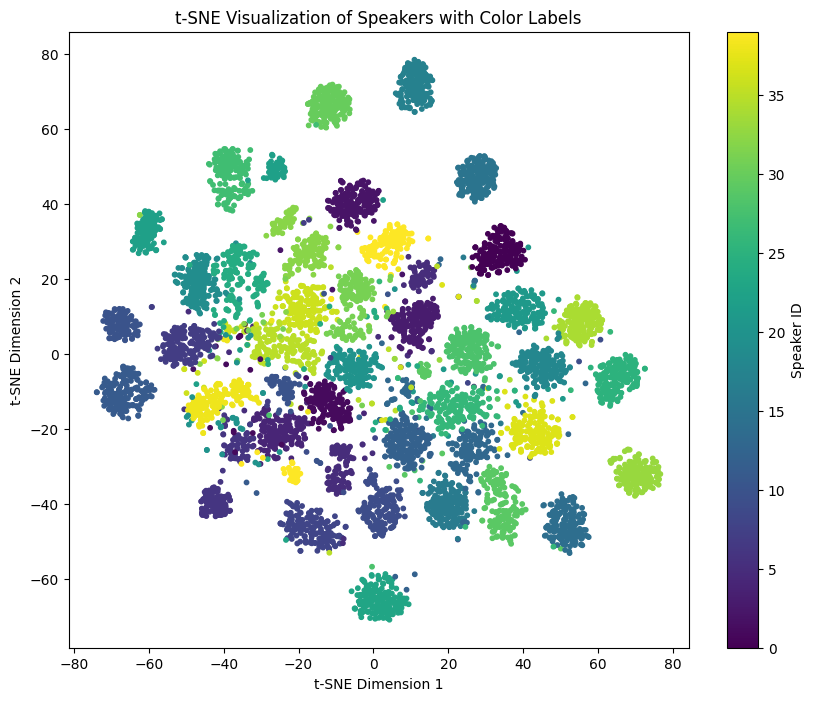

In [98]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


# Apply t-SNE for dimensionality reduction (reduce to 2D)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_t)  # Apply t-SNE on feature columns only (X)

# Plot the 2D t-SNE result and color by encoded speaker ID
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_encoded, cmap='viridis', s=10)  # c=y_encoded for color by speaker_id

cbar = plt.colorbar(scatter)
cbar.set_label('Speaker ID')

plt.title('t-SNE Visualization of Speakers with Color Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()



The t-SNE visualization effectively reduces the high-dimensional speaker data to two dimensions, allowing for a visual representation of the clustering of speaker samples. The clusters show a clear separation for most speakers, which suggests that the dataset’s features (likely MFCCs) contain enough information to differentiate between speakers. However, some clusters show overlap, which might indicate similarities between certain speakers or noise in the data.